<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To Do

- [ ] Improve projections.
- [X] Change 68% confidence interval error bars to 95% or 99.7%.
- [X] Add US states projections for confirmed cases & deaths.
- [ ] Add Canadian provincial projections for confirmed cases & deaths.

### What can be done to improve projections?

- [ ] Do not factor zero values into dataset to fit curve to.
- [ ] Fit derivative curve instead of sigmoid curve.
- [ ] Try weighting newer values as more important.
- [ ] Use lognormal probability density function instead of sigmoid.

In [1]:
!pip install uncertainties

     |████████████████████████████████| 235kB 4.3MB/s 
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96457 sha256=a4414b099e985330199027085b4fbaf4fb6a002756cf782cc45ebb1264748ea8
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built uncertainties


In [0]:
from uncertainties import ufloat
import numpy as np
import pandas as pd
from uncertainties import unumpy as unp
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from datetime import date, datetime, timedelta

In [0]:
def sigmoid(x, a, b, c):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """

  result = b * (1-1/(1+np.exp(c * (x - a))))

  return result

def usigmoid(x, a, b, c):
  result = b * (1-1/(1+unp.exp(c * (x - a))))

  return result


# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def sigmoid_derivative(x, a, b, c):
  sigma = sigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def usigmoid_derivative(x, a, b, c):
  sigma = usigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def sigmoidal_max_daily_growth_rate(a, b, c):
  return usigmoid_derivative(a, a, b, c)

In [0]:
def log_growth_rate_domain(growth_rate_curve, *args):
  return unp.log(growth_rate_curve(*args))

In [0]:
def fit_growth(curve_function, xs, ys):
  """
  Args:
  - curve_function: A 3-parameter function of x that produces a growth rate at a
    particular time. The first parameter should be a vertical scalar (usually
    equal to supremum of cumulative time series). The second parameter should be
    a horizontal shift. The third parameter should control onset rate in some
    fashion.
  - xs: Times of data points in time series to fit curve to.
  - ys: Magnitudes of data points in time series to fit curve to.
  Returns:
  - If convergent, returns a list of ufloats containing nominal parameters for
    `curve_function` with standard deviations calculated from the fit's
    covariance matrix diagonal.
  - If divergent, returns None.
  """

  initial_guesses = [max(ys)/2, 0, 0]
  while True:
    try:
      popt, pcov = curve_fit(curve_function, xs, ys, p0=initial_guesses, maxfev=500*(len(xs)+1))
      break
    except RuntimeError:
      initial_guesses[0] = (initial_guesses[0] + 1) * 1.5
  
  convergent = all([param > 0 for
                    param in
                    popt]) and all([invcov != 0 for
                                    invcov in
                                    1/pcov.flatten()])
  
  if convergent:
    return [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]

In [7]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv")

ts_df

Province/States    Country/Region  ...  4/2/2020  4/3/2020
0         Confirmed          Globally  ...  896450.0  972303.0
1            Deaths          Globally  ...   45525.0   50321.0
2         Confirmed             China  ...   82724.0   82802.0
3         Confirmed  Outside of China  ...  813726.0  889501.0
4            Deaths             China  ...    3327.0    3331.0
..              ...               ...  ...       ...       ...
254          Deaths               NaN  ...    3279.0    3438.0
255       Confirmed               NaN  ...  216912.0  247473.0
256          Deaths               NaN  ...    4565.0    5600.0
257       Confirmed               NaN  ...    4702.0    5263.0
258          Deaths               NaN  ...     127.0     164.0

[259 rows x 77 columns]

# Confirmed Cases

## By Country

### Aggregated

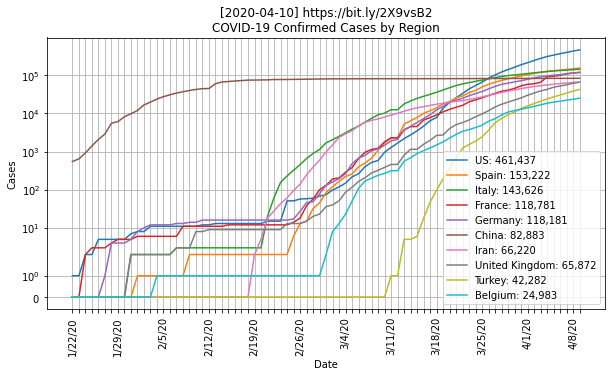

In [8]:
ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_confirmed_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_confirmed_df.index[:legend_size]:
  ax.plot(ts_only_confirmed_df.loc[region], label=f"{region}: {ts_only_confirmed_df.loc[region][-1]:,}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Cases")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

In [9]:
ts_global_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_global_confirmed_df

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
4/5/20     1272115
4/6/20     1345101
4/7/20     1426096
4/8/20     1511104
4/9/20     1595350
Length: 79, dtype: object

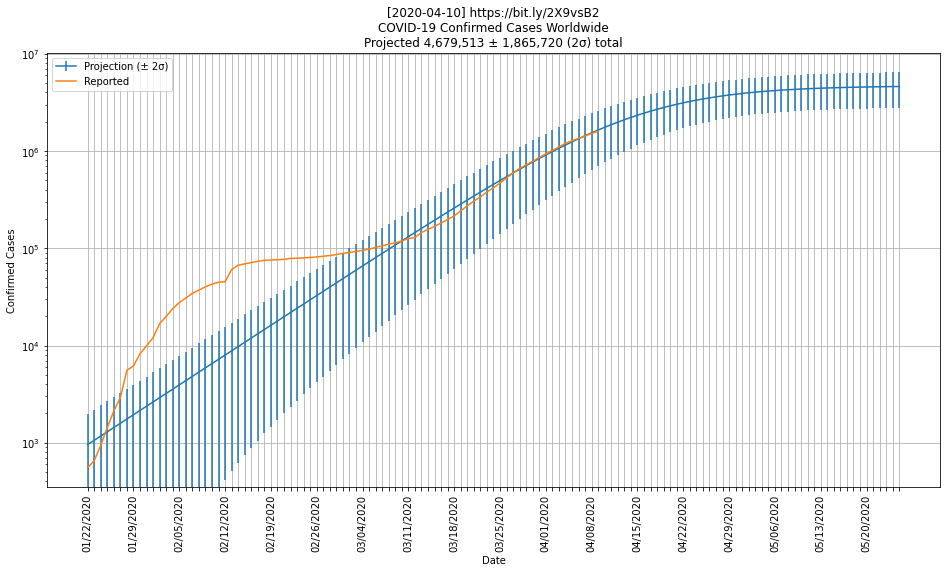

In [10]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_global_confirmed_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
fig, ax = plt.subplots(1, figsize=(16, 8))

days_to_plot = 125

if u_popt is not None:
  u_ys = [curve(x) for x in range(days_to_plot)]
  ax.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
ax.errorbar(x=range(ts_global_confirmed_df.size), y=ts_global_confirmed_df, label="Reported")

ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")

day_zero = datetime(2020, 1, 22, 0, 0)

ax.set_xticks(range(days_to_plot))
ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

plt.setp(ax.get_xmajorticklabels(), rotation=90)

i = 0
for label in ax.get_xmajorticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

ax.grid()
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")

plt.show()

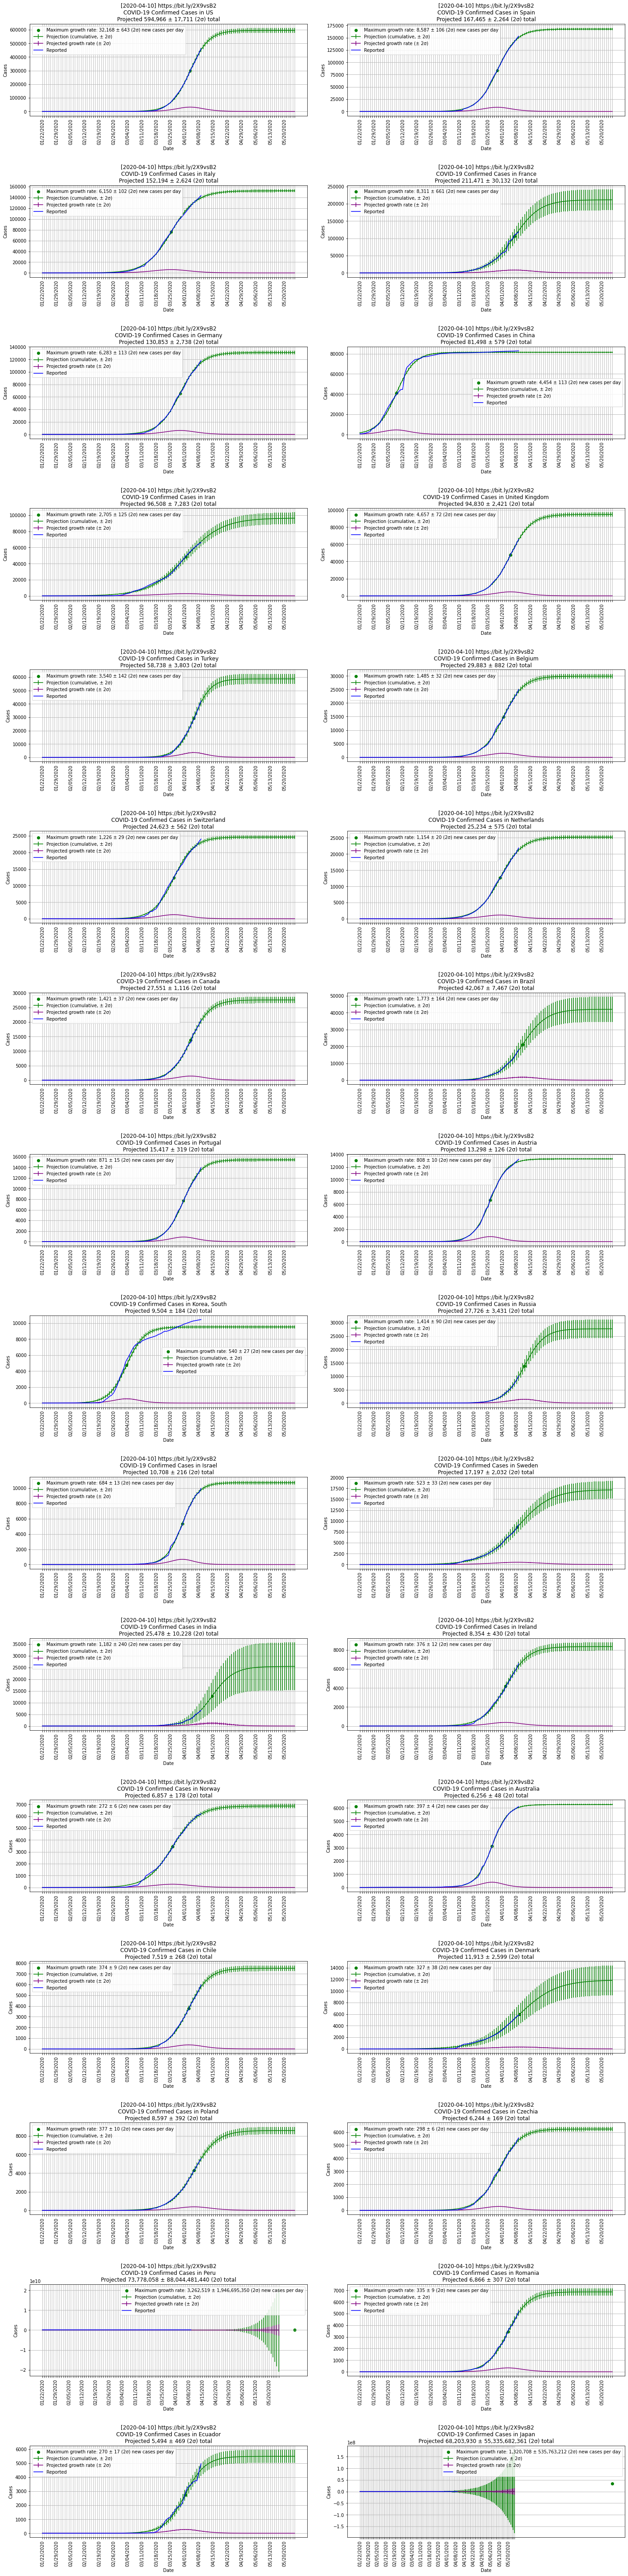

In [11]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:min(plot_top_n_countries, len(ts_only_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [12]:
ts_us_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

ts_us_confirmed_df = ts_us_confirmed_df.drop(["UID", "iso2", "iso3", "code3",
                                              "FIPS", "Admin2",
                                              "Country_Region", "Lat", "Long_",
                                              "Combined_Key"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_confirmed_df

1/22/20  1/23/20  1/24/20  ...  4/7/20  4/8/20  4/9/20
Province_State                                       ...                        
New York                        0        0        0  ...  139875  151061  161779
New Jersey                      0        0        0  ...   44416   47437   51027
Michigan                        0        0        0  ...   18970   20346   21504
California                      0        0        0  ...   17351   18897   19710
Massachusetts                   0        0        0  ...   15202   16790   18941
Pennsylvania                    0        0        0  ...   14853   16631   18300
Louisiana                       0        0        0  ...   16284   17030   18283
Florida                         0        0        0  ...   14545   15456   16364
Illinois                        0        0        1  ...   12271   15078   15079
Texas                           0        0        0  ...    8925    9777   11208
Georgia                         0        0        0  ...    8822    9901   10566
Connecticut                     0        0        0  ...    7781    7781    9784
Washington                      1        1        1  ...    8692    9276    9639
Indiana                         0        0        0  ...    5510    5943    6351
Maryland                        0        0        0  ...    4371    5529    6185
Colorado                        0        0        0  ...    5429    5655    5655
Ohio                            0        0        0  ...    4782    5148    5512
Tennessee                       0        0        0  ...    4139    4363    4634
Virginia                        0        0        0  ...    3335    3645    4042
North Carolina                  0        0        0  ...    3299    3499    3736
Missouri                        0        0        0  ...    3130    3209    3432
Arizona                         0        0        0  ...    2870    3036    3018
Wisconsin                       0        0        0  ...    2578    2710    2886
South Carolina                  0        0        0  ...    2417    2417    2793
Alabama                         0        0        0  ...    2169    2328    2703
Nevada                          0        0        0  ...    2124    2259    2456
Mississippi                     0        0        0  ...    1915    2003    2260
Utah                            0        0        0  ...    1746    1855    1856
Rhode Island                    0        0        0  ...    1229    1450    1727
Oklahoma                        0        0        0  ...    1474    1526    1686
District of Columbia            0        0        0  ...    1211    1440    1523
Kentucky                        0        0        0  ...    1149    1149    1341
Oregon                          0        0        0  ...    1132    1181    1321
Iowa                            0        0        0  ...    1046    1145    1270
Minnesota                       0        0        0  ...    1069    1154    1240
Idaho                           0        0        0  ...    1170    1210    1232
Delaware                        0        0        0  ...     928    1116    1209
Arkansas                        0        0        0  ...     946    1000    1119
Kansas                          0        0        0  ...     912    1046    1116
New Mexico                      0        0        0  ...     876     902     865
New Hampshire                   0        0        0  ...     715     747     819
Puerto Rico                     0        0        0  ...     573     620     683
Vermont                         0        0        0  ...     575     605     628
Nebraska                        0        0        0  ...     447     519     568
Maine                           0        0        0  ...     519     537     560
West Virginia                   0        0        0  ...     412     483     514
South Dakota                    0        0        0  ...     320     393     447
Hawaii                          0        0        0  ... 

### Projections

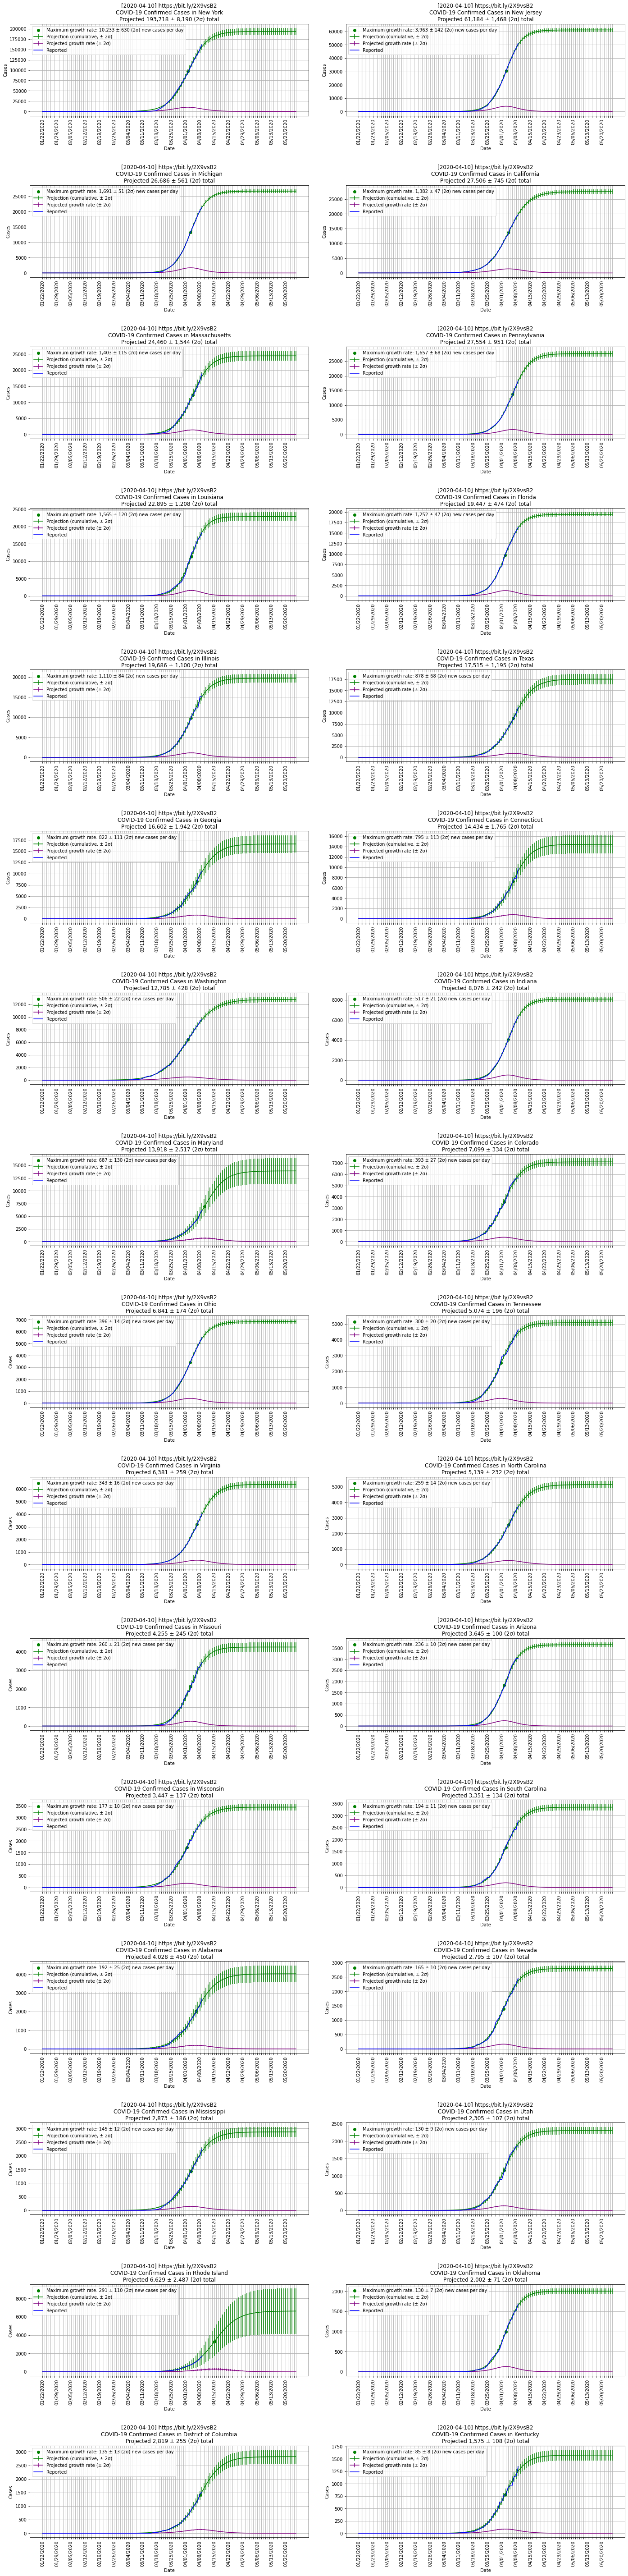

In [13]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_confirmed_df[:min(plot_top_n_states, len(ts_us_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev * 2):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

# Deaths

## By Country

### Aggregated

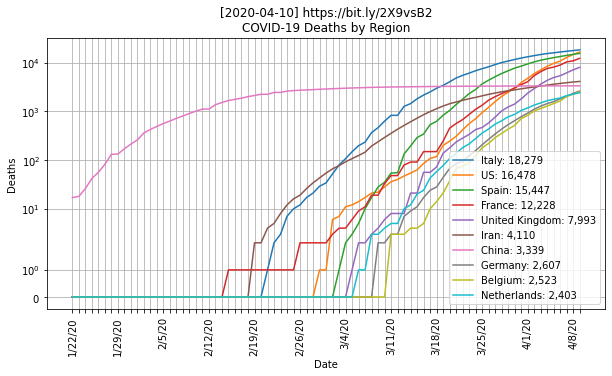

In [14]:
ts_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

ts_only_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_deaths_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_deaths_df.index[:legend_size]:
  ax.plot(ts_only_deaths_df.loc[region], label=f"{region}: {ts_only_deaths_df.loc[region][-1]:,}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Deaths")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

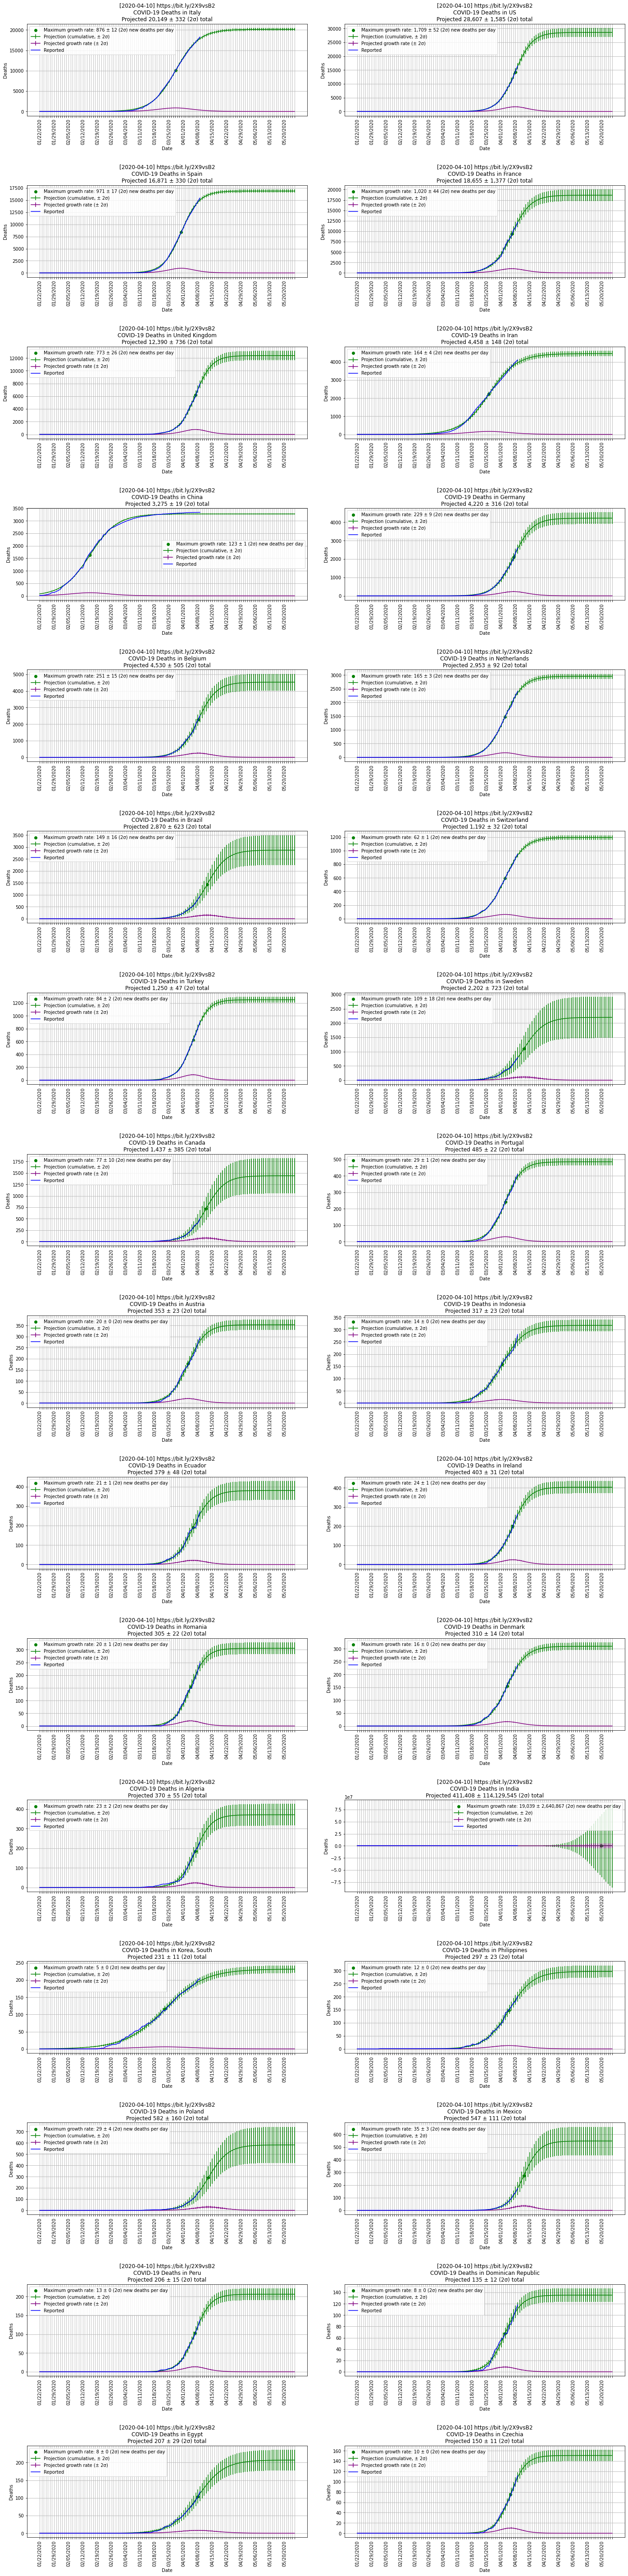

In [15]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_deaths_df[:min(plot_top_n_countries, len(ts_only_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [16]:
ts_us_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

ts_us_deaths_df = ts_us_deaths_df.drop(["UID", "iso2", "iso3", "code3",
                                           "FIPS", "Admin2",
                                           "Country_Region", "Lat", "Long_",
                                           "Combined_Key", "Population"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_deaths_df

1/22/20  1/23/20  1/24/20  ...  4/7/20  4/8/20  4/9/20
Province_State                                       ...                        
New York                        0        0        0  ...    5489    6268    7067
New Jersey                      0        0        0  ...    1232    1504    1709
Michigan                        0        0        0  ...     845     959    1076
Louisiana                       0        0        0  ...     582     652     702
California                      0        0        0  ...     432     495     544
Massachusetts                   0        0        0  ...     356     433     503
Illinois                        0        0        0  ...     308     462     462
Washington                      0        0        0  ...     400     426     456
Connecticut                     0        0        0  ...     277     326     380
Georgia                         0        0        0  ...     329     362     379
Florida                         0        0        0  ...     283     309     354
Pennsylvania                    0        0        0  ...     247     318     345
Indiana                         0        0        0  ...     173     203     245
Ohio                            0        0        0  ...     167     193     213
Texas                           0        0        0  ...     160     189     210
Colorado                        0        0        0  ...     179     193     193
Maryland                        0        0        0  ...     103     124     138
Wisconsin                       0        0        0  ...      92     100     111
Virginia                        0        0        0  ...      66      66     109
Tennessee                       0        0        0  ...      72      80      94
Missouri                        0        0        0  ...      65      86      93
Arizona                         0        0        0  ...      73      80      89
Nevada                          0        0        0  ...      72      72      81
Oklahoma                        0        0        0  ...      67      79      80
Mississippi                     0        0        0  ...      60      67      76
North Carolina                  0        0        0  ...      53      66      76
Kentucky                        0        0        0  ...      65      65      73
Alabama                         0        0        0  ...      64      66      70
South Carolina                  0        0        0  ...      51      51      67
Minnesota                       0        0        0  ...      34      39      50
Oregon                          0        0        0  ...      29      33      44
Rhode Island                    0        0        0  ...      30      35      43
Kansas                          0        0        0  ...      29      34      42
Puerto Rico                     0        0        0  ...      23      24      33
District of Columbia            0        0        0  ...      22      27      32
Iowa                            0        0        0  ...      25      27      29
Delaware                        0        0        0  ...      16      19      23
Vermont                         0        0        0  ...      23      23      23
New Hampshire                   0        0        0  ...       9      13      21
Arkansas                        0        0        0  ...      18      18      21
Idaho                           0        0        0  ...      13      15      18
New Mexico                      0        0        0  ...      13      13      16
Maine                           0        0        0  ...      12      14      16
Nebraska                        0        0        0  ...      10      12      14
Utah                            0        0        0  ...      13      13      13
Alaska                          0        0        0  ...       6       7       7
South Dakota                    0        0        0  ...       6       6       6
Montana                         0        0        0  ... 

### Projections

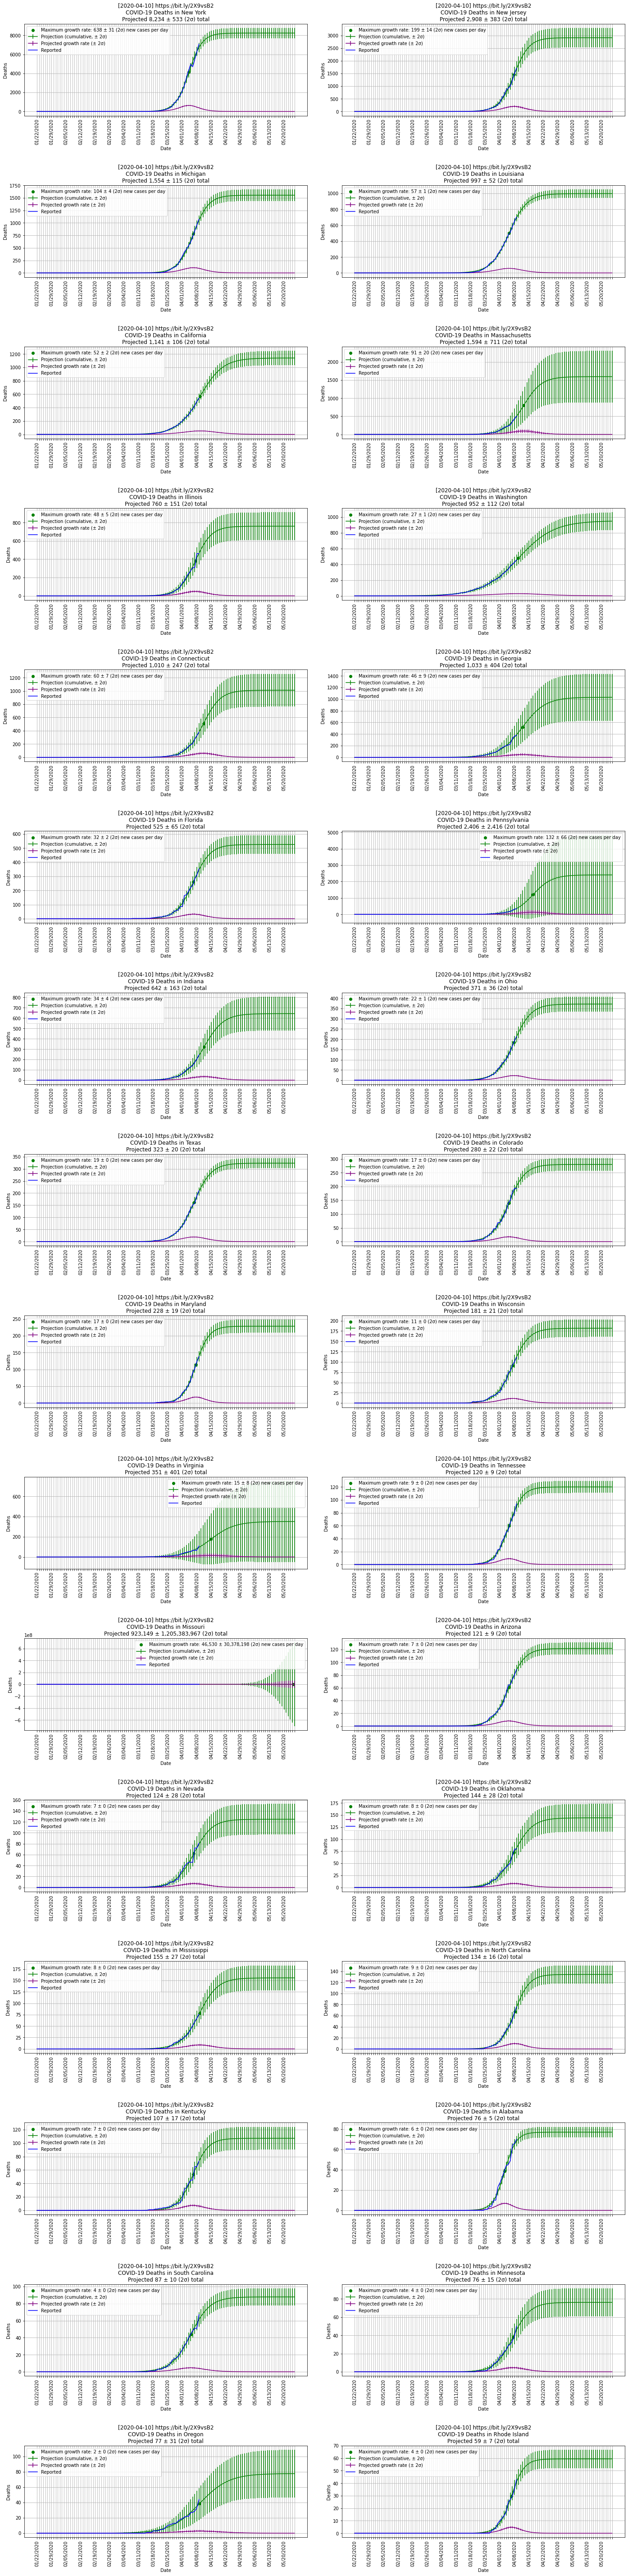

In [17]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_deaths_df[:min(plot_top_n_states, len(ts_us_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value):,} ± {int(inflection_y.std_dev):,} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By Country

### Aggregated

In [18]:
ts_only_consol_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_only_consol_deaths_df

1/22/20       17
1/23/20       18
1/24/20       26
1/25/20       42
1/26/20       56
           ...  
4/5/20     69374
4/6/20     74565
4/7/20     81865
4/8/20     88338
4/9/20     95455
Length: 79, dtype: object

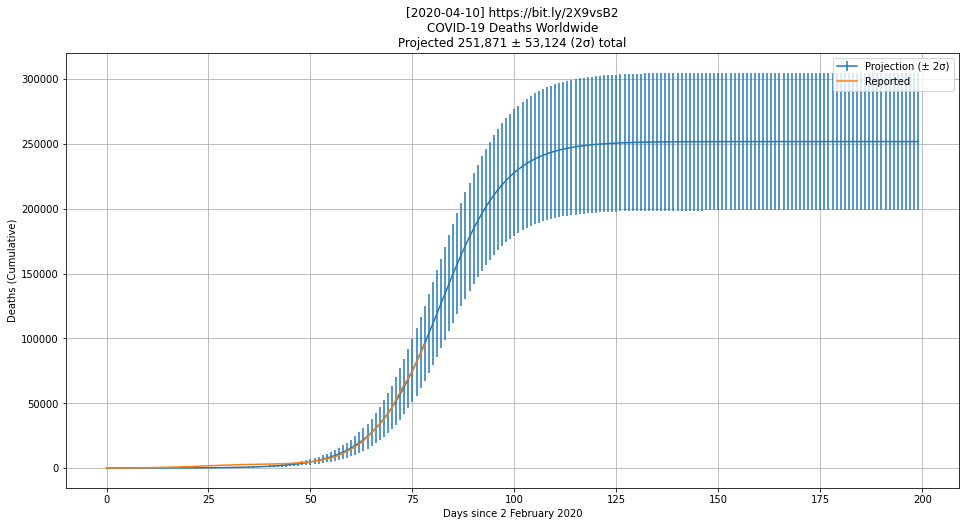

In [20]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_only_consol_deaths_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
plt.figure(figsize=(16, 8))
if u_popt is not None:
  u_ys = [curve(x) for x in range(200)]
  plt.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
plt.errorbar(x=range(ts_only_consol_deaths_df.size), y=ts_only_consol_deaths_df, label="Reported")

plt.title(f"[{date.today()}] https://bit.ly/2X9vsB2\nCOVID-19 Deaths Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value):,} ± {int(u_popt[1].std_dev * 2):,} (2σ) total'}")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Deaths (Cumulative)")
#plt.yscale("symlog")
plt.legend()

plt.show()